In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
df= pd.read_csv("alquileres_completo_limpio.csv")

In [2]:
shapedforiginal=df.shape
print(f"Empezamos con {df.shape}")
#eliminar todas las columnas con mas de un 25% de nans
umbral_nans = 0.25  
df = df.loc[:, df.isnull().mean() < umbral_nans]
print(f"Ahora nos quedamos con {df.shape}")

#eliminar todas las filas que sean en mismo inmueble usando la columna "identificador"
df = df.drop_duplicates()
print(f"Ahora nos quedamos con {df.shape}")

#eliminar todas las filas que tengan "habitaciones" o "baños" con nan, porque van a ser de las columnas mas importantes
#tambien superficie, poque solo nos cargamos unas muy pocas además que es importante
df = df.dropna(subset=['habitaciones', 'baños','superficie'])
print(f"Ahora nos quedamos con {df.shape}")

#arreglar coordenadas y poner latitud y longitud
df["latitud"] = df["coordenadas"].str.split(",").str[0].str.strip().astype(float, errors='ignore')
df["longitud"] = df["coordenadas"].str.split(",").str[1].str.strip().astype(float, errors='ignore')
df = df.drop(['coordenadas'], axis=1)

Empezamos con (27467, 56)
Ahora nos quedamos con (27467, 49)
Ahora nos quedamos con (27467, 49)
Ahora nos quedamos con (26662, 49)


In [3]:
#POR QUE ELIMINAR ESTAS COLUMNAS:
df = df.drop(['identificador'], axis=1)
#identificador: una vez quitado los dublicados, ya no nos sirve, y si queremos ver algo, nos metemos en href

df = df.drop(['comunidad_autonoma'], axis=1)
#comunidad_autonoma: porque ya esta provincia que es mas conciso

df = df.drop(['gas','agua','luz','alcantarillado','comedor','calefaccion','lavadero','calle_alumbrada','telefono'], axis=1)
#gas,agua,luz,alcantarillado,comedor, calefaccion etc irrelevantes porque todas tienen de una manera u otra si no no es un piso o es un piso que no queremos predecir

df = df.drop(['adaptado_a_personas_con_movilidad_reducida'], axis=1)
#no es muy significativo para la mayoría, y no existen muchos valores, y seguro que muchas veces no rellenan la casilla

df = df.drop(['agencia'], axis=1)
#agencia: no importa quien ofrezca el piso, aparte tampoco se puede predecir

df = df.drop(['emisiones'], axis=1)
df = df.rename(columns={'consumo': 'consumo_energetico'})
#consumo y emisiones es lo mismo, asi que borramos emisiones y renombramos a consumo_energetico

df = df.drop(['superficie_construida'], axis=1)
#superficie y superficie_construida es lo mismo, asi que nos quedamos con superficie

In [4]:
#Toda la morralla que no está clara puntuaremos si tiene o no, y lo juntamos para hacer una columna "nuestra" con los criterios que hemos elegido
puntuaciones = {
    'aire_acondicionado': {'Si': 1, 'No': 0, 'Sin especificar': 0},
    'sistema_de_seguridad': {'Si': 3, 'Sin especificar': 0},
    'puerta_blindada': {'Si': 3, 'Sin especificar': 0},
    'vidrios_dobles': {'Si': 2, 'No': 0, 'Sin especificar': 0},
    'chimenea': {'Si': 8, 'No': 0, 'Sin especificar': 0},
    'ascensor': {'Si': 10, 'No': 0, 'Sin especificar': 0},
    'portero_automatico': {'Si': 1, 'Sin especificar': 0},
    'orientacion': {'Sin especificar': 0, 'SUR': 3, 'ESTE': 2, 'SURESTE': 3, 'OESTE': 2, 'SUROESTE': 1, 'NORTE': 0, 'NORESTE': 1, 'NOROESTE': 1},
    'armarios_empotrados': {'Si': 3, 'No': 0, 'Sin especificar': 0},
    'cocina_equipada': {'Si': 2, 'No': 0, 'Sin especificar': 0},
    'terraza': {'Si': 9, 'No': 0, 'Sin especificar': 0},
    'balcon': {'Si': 6, 'No': 0, 'Sin especificar': 0},
    'jardin': {'Si': 9, 'No': 0, 'Sin especificar': 0},
    'piscina': {'Si': 10, 'No': 0, 'Sin especificar': 0},
    'trastero': {'Si': 5, 'No': 0, 'Sin especificar': 0},
    'garaje': {'Si': 10, 'No': 0, 'Sin especificar': 0},
    'amueblado': {'Si': 1, 'No': 0, 'Sin especificar': 0},
    'se_aceptan_mascotas': {'Si': 3, 'No': 0, 'Sin especificar': 0},
    'gastos_de_comunidad': {'Si': 0, 'No': 3, 'Sin especificar': 0},
    'consumo_energetico': {
        'G, G': 0, 'G, F': 0.5, 'G, E': 1, 'G, D': 1.5, 'G, C': 2, 'G, B': 2.5,
        'F, G': 0.5, 'F, F': 1, 'F, E': 1.5, 'F, D': 2, 'F, C': 2.5,
        'E, G': 1, 'E, F': 1.5, 'E, E': 2, 'E, D': 2.5, 'E, C': 3, 'E, B': 3.5,
        'D, G': 1.5, 'D, F': 2, 'D, E': 2.5, 'D, D': 3, 'D, C': 3.5, 'D, B': 4, 'D, A': 4.5,
        'C, G': 2, 'C, F': 2.5, 'C, E': 3, 'C, D': 3.5, 'C, C': 4, 'C, B': 4.5, 'C, A': 5,
        'B, G': 2.5, 'B, F': 3, 'B, E': 3.5, 'B, D': 4, 'B, C': 4.5, 'B, B': 5, 'B, A': 5.5,
        'A, G': 3, 'A, F': 3.5, 'A, E': 4, 'A, D': 4.5, 'A, C': 5, 'A, B': 5.5, 'A, A': 6
    }
}
def calcular_puntuacion(fila):
    puntuacion = 0
    for col, valores in puntuaciones.items():
        if col in fila and fila[col] in valores:
            puntuacion += valores[fila[col]]
    return puntuacion

df['puntuacion_servicios'] = df.apply(calcular_puntuacion, axis=1)
df = df.drop(['aire_acondicionado', 'sistema_de_seguridad', 'puerta_blindada', 'vidrios_dobles', 'chimenea', 'ascensor', 'portero_automatico', 'orientacion', 'armarios_empotrados', 'cocina_equipada', 'terraza', 'balcon', 'jardin', 'piscina', 'trastero', 'garaje', 'amueblado', 'se_aceptan_mascotas', 'gastos_de_comunidad', 'consumo_energetico'], axis=1)

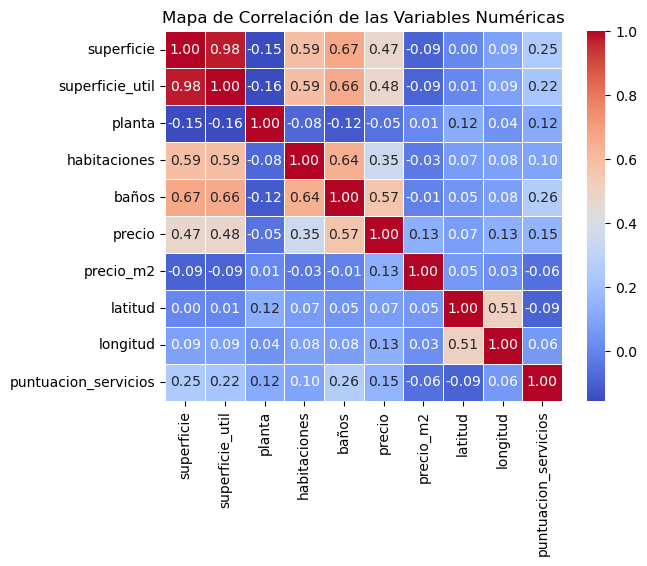

In [5]:
numericas = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numericas.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Correlación de las Variables Numéricas')
plt.show()

In [6]:
print(f"Nos quedamos con {df.shape[1]} columnas:\n{df.columns}")

Nos quedamos con 16 columnas:
Index(['nombre', 'provincia', 'href', 'superficie', 'superficie_util',
       'planta', 'habitaciones', 'baños', 'precio', 'precio_m2',
       'actualizacion', 'timestamp', 'tipo_de_casa', 'latitud', 'longitud',
       'puntuacion_servicios'],
      dtype='object')


In [7]:
numericas

,superficie,superficie_util,planta,habitaciones,baños,precio,precio_m2,latitud,longitud,puntuacion_servicios
0,90.0,75.0,3,2.0,1.0,750.0,8.0,36.717196,-2.639276,66.0
1,75.0,73.0,21,3.0,1.0,800.0,10.0,36.831780,-2.450107,13.0
2,95.0,90.0,2,3.0,1.0,800.0,8.0,36.828726,-2.449357,9.0
3,100.0,100.0,0,2.0,2.0,850.0,8.0,36.835574,-2.611331,34.0
4,90.0,75.0,1,2.0,1.0,1250.0,13.0,36.717196,-2.639276,56.5
...,...,...,...,...,...,...,...,...,...,...
27462,50.0,48.0,2,2.0,1.0,700.0,14.0,35.287993,-2.946579,0.0
27463,75.0,75.0,0,3.0,2.0,1000.0,13.0,35.297922,-2.938670,14.0
27464,115.0,100.0,1,3.0,2.0,1200.0,10.0,35.276299,-2.942723,13.0
27465,70.0,70.0,3,2.0,1.0,850.0,12.0,35.296357,-2.940809,0.0


667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 829751.4375 - mae: 454.9099 - val_loss: 275019.6875 - val_mae: 209.0819
Epoch 467/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 739183.7500 - mae: 445.4514 - val_loss: 265313.2812 - val_mae: 204.3635
Epoch 468/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 652556.0625 - mae: 444.9005 - val_loss: 265729.5312 - val_mae: 204.1622
Epoch 469/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 751372.1875 - mae: 455.1248 - val_loss: 273511.9688 - val_mae: 207.9275
Epoch 470/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 724458.5000 - mae: 449.0978 - val_loss: 269108.3125 - val_mae: 207.8682
Epoch 471/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 679615.1875 - mae: 442.1985 - val_loss: 260685.2812 - val_mae: 200.3394
Epoch 472/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 896518.4375 - mae: 460.3171 - val_loss: 272551.1562 - val_mae: 209.5955
Epoch 473/500
667/667 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 791015

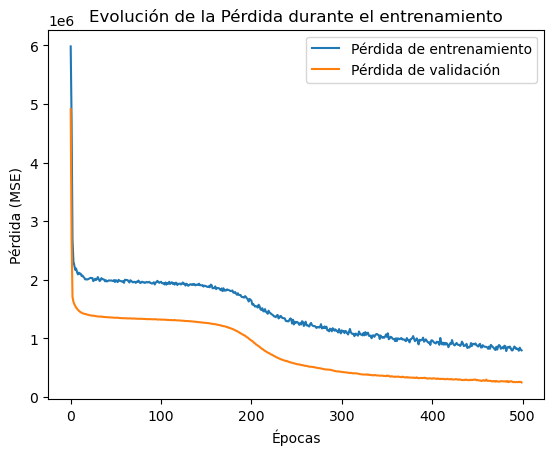

In [8]:


# Asumiendo que 'numericas' es tu DataFrame
# Selecciona las columnas que usarás como características y la variable objetivo (precio)
X = numericas.drop(columns=["precio"])  # Variables predictoras (sin la columna "precio")
y = numericas["precio"] 

# Dividir en conjunto de entrenamiento y conjunto de prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos (esto es importante para redes neuronales)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inicializamos el modelo
model = Sequential()

# Capa de Entrada
model.add(Input(shape=(X_train.shape[1],)))  # X_train.shape[1] es el número de características

# Capas Ocultas
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=1))  

model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse", metrics=["mae"])  # mse es la función de pérdida para regresión

early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

mse_train = model.evaluate(X_train, y_train)
mse_test = model.evaluate(X_test, y_test)

print(f"MSE en entrenamiento: {mse_train}")
print(f"MSE en prueba: {mse_test}")

print(f"MAE en entrenamiento: {history.history['mae'][-1]}")
print(f"MAE en validación: {history.history['val_mae'][-1]}")

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.show()